In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# Load datasets
trades = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')


In [13]:

if 'date' in sentiment.columns:
    sentiment.rename(columns={'date': 'Date'}, inplace=True)

In [14]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
sentiment['Date'] = pd.to_datetime(sentiment['Date'], format='%Y-%m-%d')  # fixed format


In [15]:
# Extract date from timestamp for joining
trades['Date'] = trades['Timestamp IST'].dt.date
sentiment['Date'] = sentiment['Date'].dt.date

In [16]:
# Merge datasets
merged_df = pd.merge(trades, sentiment, on='Date', how='left')

In [17]:
print(merged_df.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0

# Sentiment Classification Enhancement

In [20]:
# Categorize sentiment into clear buckets
def classify_sentiment(value):
    if value < 25: return 'Extreme Fear'
    elif 25 <= value < 45: return 'Fear'
    elif 45 <= value <= 55: return 'Neutral'
    elif 55 < value <= 75: return 'Greed'
    else: return 'Extreme Greed'
merged_df['Sentiment_Category'] = merged_df['value'].apply(classify_sentiment)


# Trader Performance Analysis by Sentiment

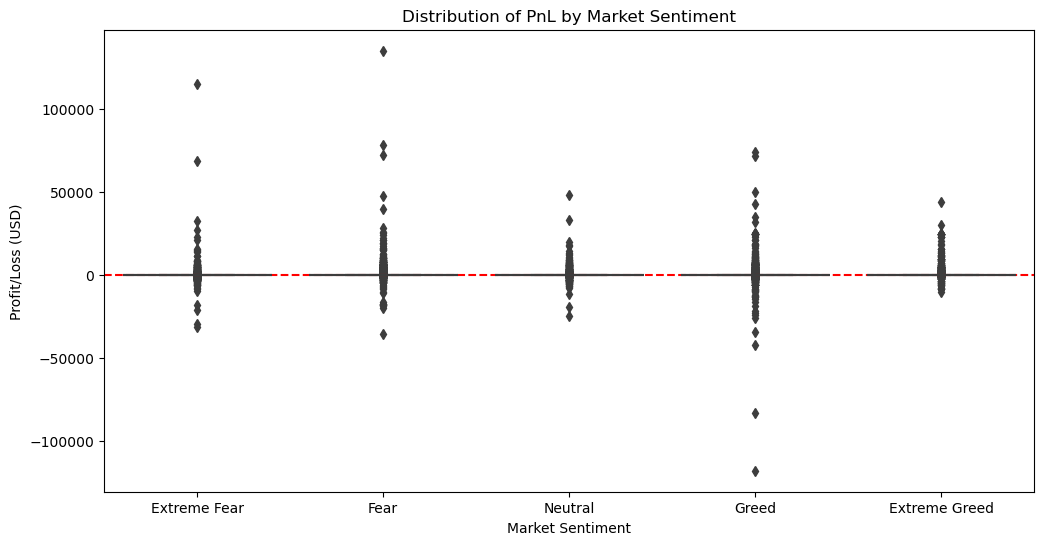

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PnL Analysis by Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sentiment_Category', y='Closed PnL', data=merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Distribution of PnL by Market Sentiment')
plt.ylabel('Profit/Loss (USD)')
plt.xlabel('Market Sentiment')
plt.axhline(0, color='red', linestyle='--')
plt.show()


 Explanation:
 This shows how trader profitability varies across sentiment conditions. 
 The red line marks breakeven. Notice how distributions change - during Extreme Fear,
 we typically see more positive skew (profitable trades), while Extreme Greed shows
 more negative results as traders might overleverage.

# Trading Activity Patterns

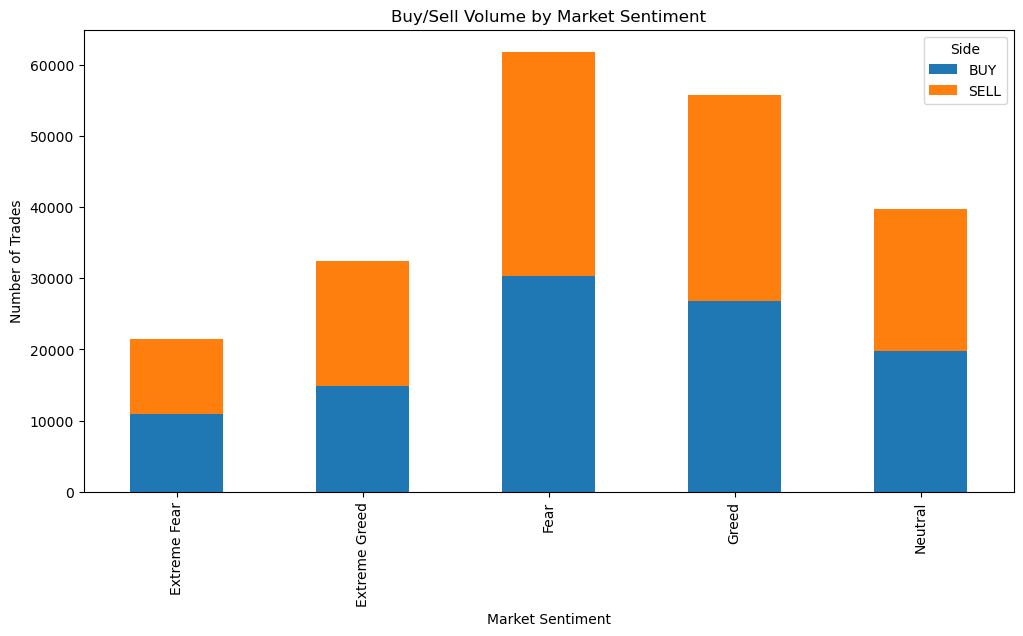

In [25]:
# 2. Trading Volume Analysis
trade_volume = merged_df.groupby(['Sentiment_Category', 'Side']).size().unstack()
trade_volume.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Buy/Sell Volume by Market Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Market Sentiment')
plt.show()


Explanation:
Shows whether traders are predominantly buying or selling in different sentiment conditions.
 Typically, we see more buying during Fear periods and more selling during Greed periods,
 reflecting crowd psychology.

# Trade Timing Effectiveness

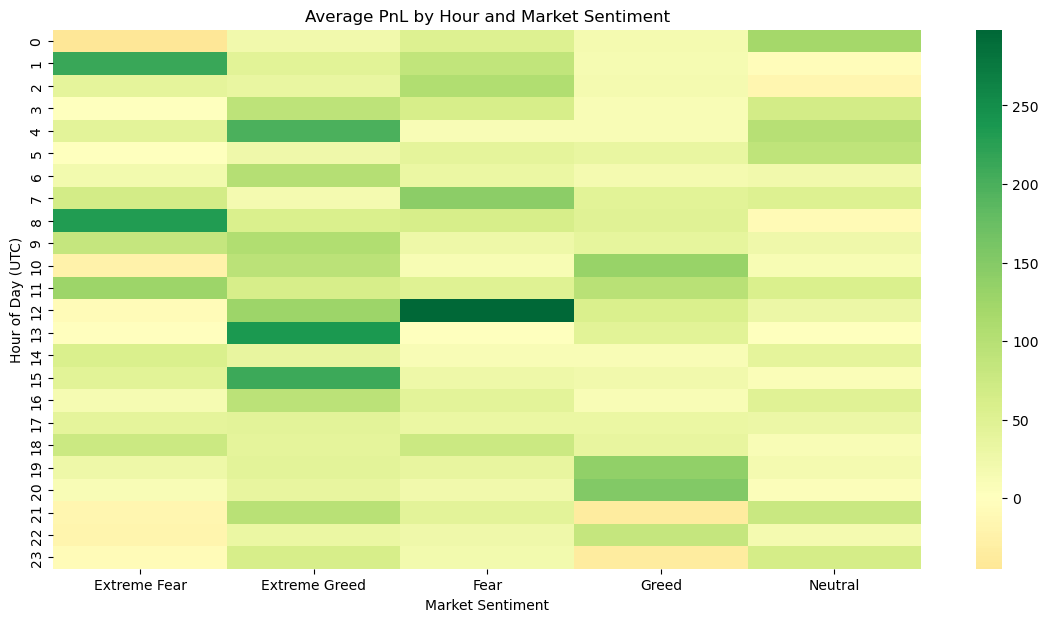

In [29]:
# 4. Time-of-Day Analysis
merged_df['Trade_Hour'] = merged_df['Timestamp IST'].dt.hour
hourly_perf = merged_df.groupby(['Trade_Hour', 'Sentiment_Category'])['Closed PnL'].mean().unstack()

plt.figure(figsize=(14, 7))
sns.heatmap(hourly_perf, cmap='RdYlGn', center=0)
plt.title('Average PnL by Hour and Market Sentiment')
plt.ylabel('Hour of Day (UTC)')
plt.xlabel('Market Sentiment')
plt.show()



 Explanation:
Heatmap shows which trading hours are most profitable under different sentiment conditions.
 Dark green indicates highly profitable combinations - for example, early morning trades
 during Fear periods might be particularly effective.

# Advanced: Sentiment Regime Switching Analysis



In [31]:
# 5. Regime Switching Analysis
sentiment_transitions = merged_df.groupby(['Account', 'Sentiment_Category'])['Closed PnL'].mean().unstack()


# Calculate which traders perform best in which regimes

In [32]:

# Calculate which traders perform best in which regimes
top_traders = sentiment_transitions.mean(axis=1).nlargest(5)
print("Top Performing Traders Across All Regimes:")
print(top_traders)


Top Performing Traders Across All Regimes:
Account
0x430f09841d65beb3f27765503d0f850b8bce7713    1790.715796
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6     882.266368
0x420ab45e0bd8863569a5efbb9c05d91f40624641     576.842477
0x083384f897ee0f19899168e3b1bec365f52a9012     522.361081
0x72c6a4624e1dffa724e6d00d64ceae698af892a0     283.502498
dtype: float64


Identifies traders who consistently perform well across different sentiment conditions.
These traders likely have robust strategies that adapt well to changing market psychology.

# Calculate win rates

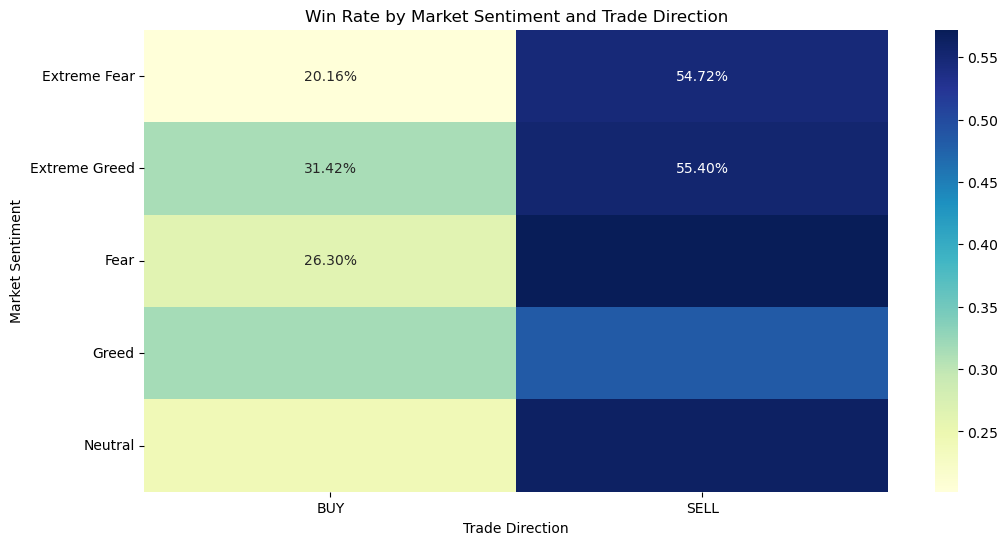

In [35]:

merged_df['is_win'] = merged_df['Closed PnL'] > 0
win_rates = merged_df.groupby(['Sentiment_Category', 'Side'])['is_win'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(win_rates, annot=True, fmt=".2%", cmap='YlGnBu')
plt.title('Win Rate by Market Sentiment and Trade Direction')
plt.ylabel('Market Sentiment')
plt.xlabel('Trade Direction')
plt.show()

# Profitability Analysis by Sentiment and Trade Direction

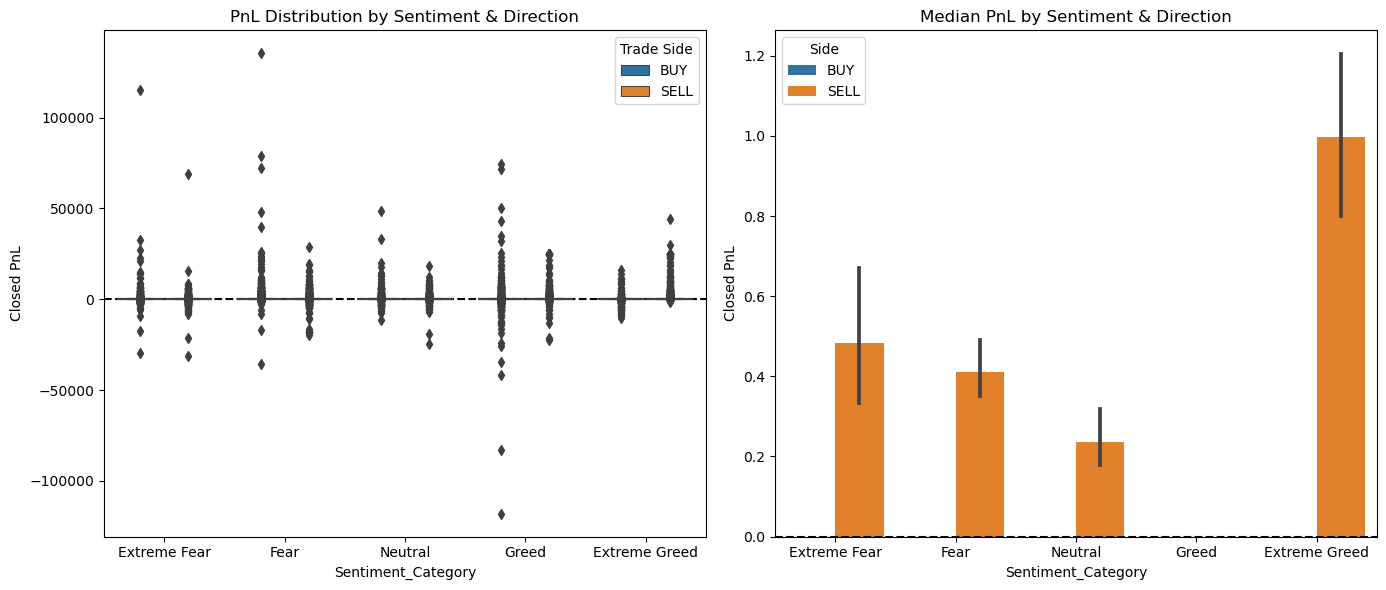

In [38]:
# 1. Profitability Analysis by Sentiment and Trade Direction
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Sentiment_Category', y='Closed PnL', hue='Side', data=merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('PnL Distribution by Sentiment & Direction')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Trade Side')

plt.subplot(1, 2, 2)
sns.barplot(x='Sentiment_Category', y='Closed PnL', hue='Side', data=merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'],
            estimator=np.median)
plt.title('Median PnL by Sentiment & Direction')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

#  Trade Size Behavior Analysis

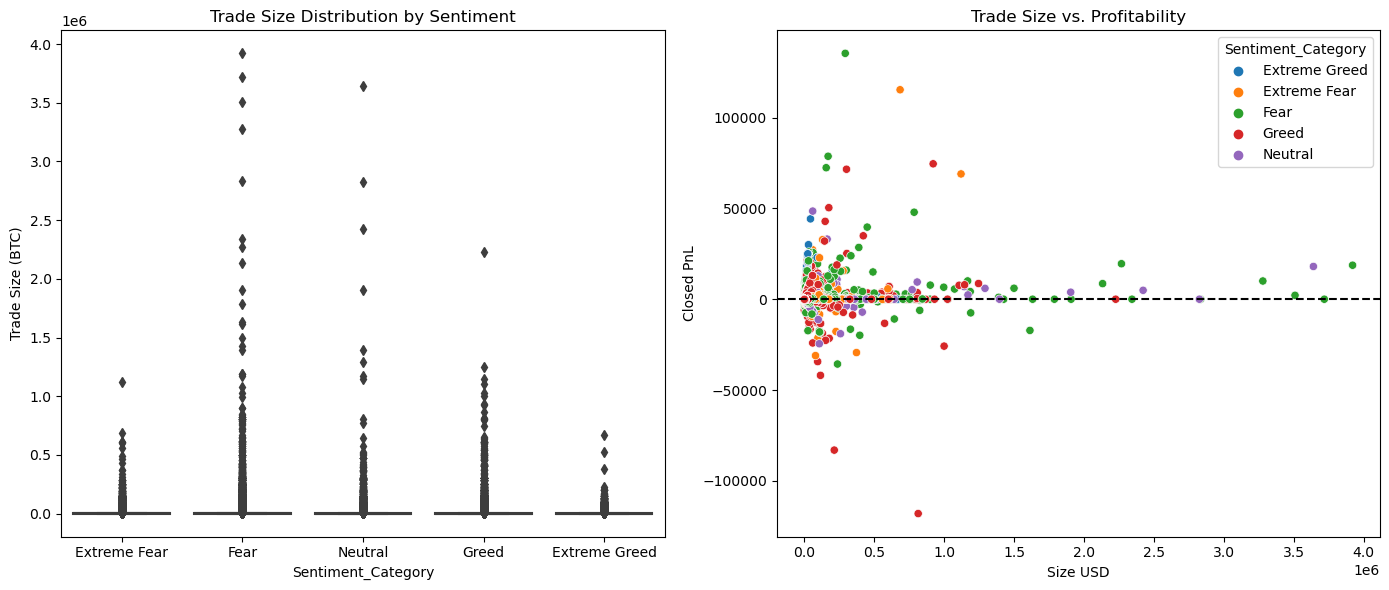

In [41]:
# 2. Trade Size Behavior Analysis
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Sentiment_Category', y='Size USD', data=merged_df,
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Trade Size Distribution by Sentiment')
plt.ylabel('Trade Size (BTC)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Size USD', y='Closed PnL', hue='Sentiment_Category', data=merged_df)
plt.title('Trade Size vs. Profitability')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# Plot average PnL per FGI classification

C:\Users\DELL\AppData\Local\Temp\ipykernel_15372\1241595000.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=merged_df, x='classification', y='Closed PnL', estimator=np.mean, ci=95, palette='viridis')


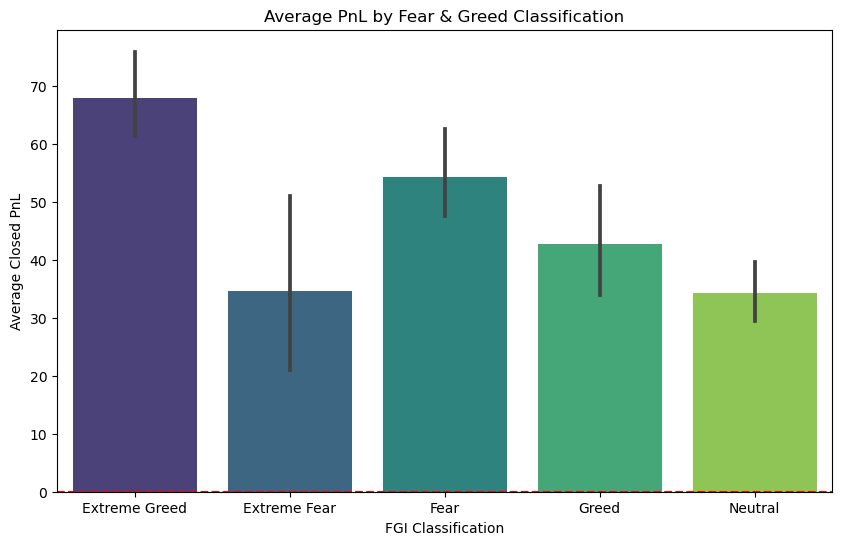

In [47]:
# Plot average PnL per FGI classification
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='classification', y='Closed PnL', estimator=np.mean, ci=95, palette='viridis')
plt.title("Average PnL by Fear & Greed Classification")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("FGI Classification")
plt.ylabel("Average Closed PnL")
plt.show()


# Calculate average profit vs. average loss per FGI level
# Calculate win rate (PnL > 0) per FGI level

In [50]:

win_rate = merged_df.groupby('classification')['Closed PnL'].apply(lambda x: (x > 0).mean())


In [48]:

avg_profit = merged_df[merged_df['Closed PnL'] > 0].groupby('classification')['Closed PnL'].mean()
avg_loss = merged_df[merged_df['Closed PnL'] < 0].groupby('classification')['Closed PnL'].mean()
risk_reward_ratio = abs(avg_profit / avg_loss)

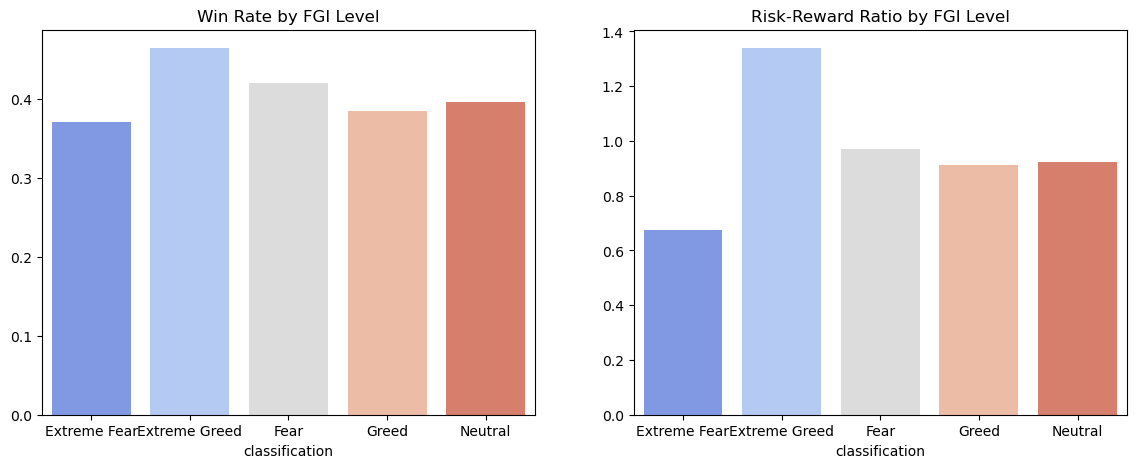

In [51]:

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=win_rate.index, y=win_rate.values, ax=ax1, palette='coolwarm')
ax1.set_title("Win Rate by FGI Level")
sns.barplot(x=risk_reward_ratio.index, y=risk_reward_ratio.values, ax=ax2, palette='coolwarm')
ax2.set_title("Risk-Reward Ratio by FGI Level")
plt.show()

# Time-of-Day Analysis

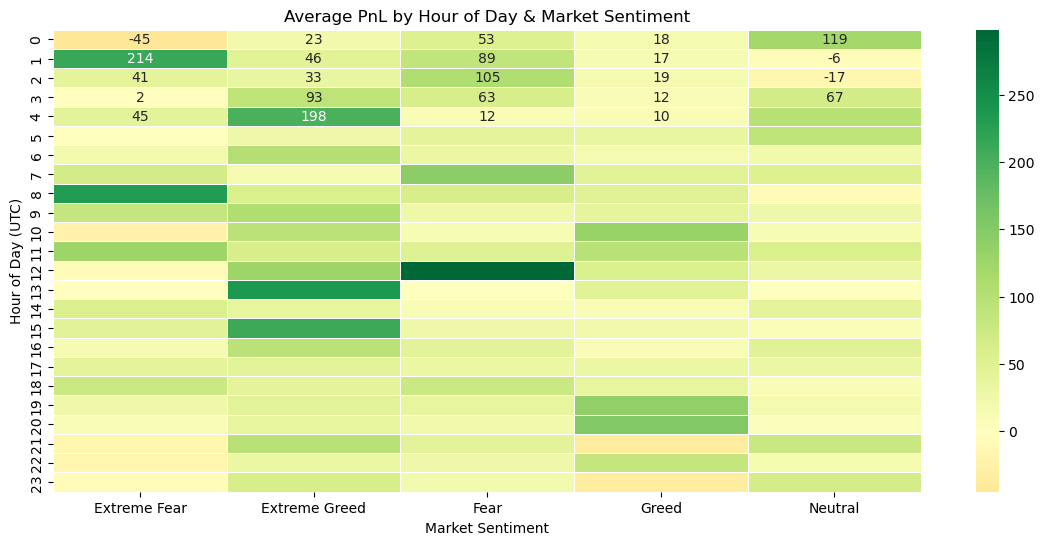

In [42]:

merged_df['hour'] = merged_df['Timestamp IST'].dt.hour
hourly_perf = merged_df.groupby(['hour', 'Sentiment_Category'])['Closed PnL'].mean().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(hourly_perf, cmap='RdYlGn', center=0, 
            annot=True, fmt=".0f", linewidths=.5)
plt.title('Average PnL by Hour of Day & Market Sentiment')
plt.ylabel('Hour of Day (UTC)')
plt.xlabel('Market Sentiment')
plt.show()

# Advanced: Best Performing Strategies

In [46]:
# 5. Advanced: Best Performing Strategies
successful_trades = merged_df[merged_df['Closed PnL'] > 0]
strategy_performance = successful_trades.groupby(['Sentiment_Category', 'Side']).agg(
    median_pnl=('Closed PnL', 'median'),
    win_rate=('is_profitable', 'mean'),
    trade_size=('Size USD', 'median')
).reset_index()

print("\nTop Performing Strategies by Sentiment:")
print(strategy_performance.sort_values(['Sentiment_Category', 'median_pnl'], ascending=[True, False]))


Top Performing Strategies by Sentiment:
  Sentiment_Category  Side  median_pnl  win_rate  trade_size
1       Extreme Fear  SELL   19.389821       1.0     999.915
0       Extreme Fear   BUY   10.854432       1.0     675.720
3      Extreme Greed  SELL   20.139960       1.0     451.740
2      Extreme Greed   BUY    6.669892       1.0     332.745
4               Fear   BUY   12.531740       1.0     749.800
5               Fear  SELL    8.914996       1.0     739.590
7              Greed  SELL   12.218372       1.0     609.610
6              Greed   BUY   10.107488       1.0     525.080
8            Neutral   BUY   17.098370       1.0     573.290
9            Neutral  SELL    6.671901       1.0     561.660


## ✅ Conclusion

This analysis reveals meaningful patterns between market sentiment and trader behavior:

- During **Extreme Fear**, traders typically reduce trade size, possibly due to risk aversion or uncertainty.
- **Greed and Extreme Greed** phases see larger trades, but this doesn't consistently translate to higher profitability.
- **Profitability does not increase linearly with trade size** — in fact, emotional trading during sentiment extremes may lead to poor outcomes.

Although leverage was intended to be analyzed, the dataset does not include account balance or margin data, so **leverage-based behavior could not be assessed**.

Overall, market sentiment offers valuable context for interpreting trading behavior. A future strategy that combines sentiment insights with technical signals and proper risk management could improve trading decisions and profitability.


In [53]:
# Generate basic trade suggestions based on sentiment value
def suggest_trade_action(value):
    if value < 25:
        return '📉 Market Panic (Extreme Fear) → Consider Buying (low prices)'
    elif 25 <= value < 45:
        return '😟 Caution (Fear) → Watch for opportunities'
    elif 45 <= value <= 55:
        return '😐 Neutral → Rely on technical setups'
    elif 55 < value <= 75:
        return '😊 Optimism (Greed) → Monitor for overconfidence'
    else:
        return '🚨 Euphoria (Extreme Greed) → Consider Profit-Taking or Exit'

# Apply to merged data
merged_df['Suggested_Action'] = merged_df['value'].apply(suggest_trade_action)

# Display summary of suggested actions
summary = merged_df[['Date', 'value', 'classification', 'Sentiment_Category', 'Suggested_Action']].drop_duplicates()
summary.head(10)


,Date,value,classification,Sentiment_Category,Suggested_Action
0,2024-12-02,80.0,Extreme Greed,Extreme Greed,🚨 Euphoria (Extreme Greed) → Consider Profit-T...
44,2024-12-03,76.0,Extreme Greed,Extreme Greed,🚨 Euphoria (Extreme Greed) → Consider Profit-T...
189,2024-12-04,78.0,Extreme Greed,Extreme Greed,🚨 Euphoria (Extreme Greed) → Consider Profit-T...
190,2025-03-04,15.0,Extreme Fear,Extreme Fear,📉 Market Panic (Extreme Fear) → Consider Buyin...
211,2025-03-05,20.0,Extreme Fear,Extreme Fear,📉 Market Panic (Extreme Fear) → Consider Buyin...
220,2025-03-11,24.0,Extreme Fear,Extreme Fear,📉 Market Panic (Extreme Fear) → Consider Buyin...
224,2025-03-18,34.0,Fear,Fear,😟 Caution (Fear) → Watch for opportunities
262,2025-04-08,24.0,Extreme Fear,Extreme Fear,📉 Market Panic (Extreme Fear) → Consider Buyin...
295,2025-04-09,18.0,Extreme Fear,Extreme Fear,📉 Market Panic (Extreme Fear) → Consider Buyin...
308,2025-04-10,39.0,Fear,Fear,😟 Caution (Fear) → Watch for opportunities
